# PyTorch quickstart tutorial

Adapted from the official pytorch documentation at https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

Start with the standard imports.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Working with data

PyTorch offers domain-specific libraries such as `TorchText <https://pytorch.org/text/stable/index.html>`_,
`TorchVision <https://pytorch.org/vision/stable/index.html>`_, and `TorchAudio <https://pytorch.org/audio/stable/index.html>`_,
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data. In this tutorial, we
use the FashionMNIST dataset. 

In [ ]:

######################################################################

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


# Look at the data

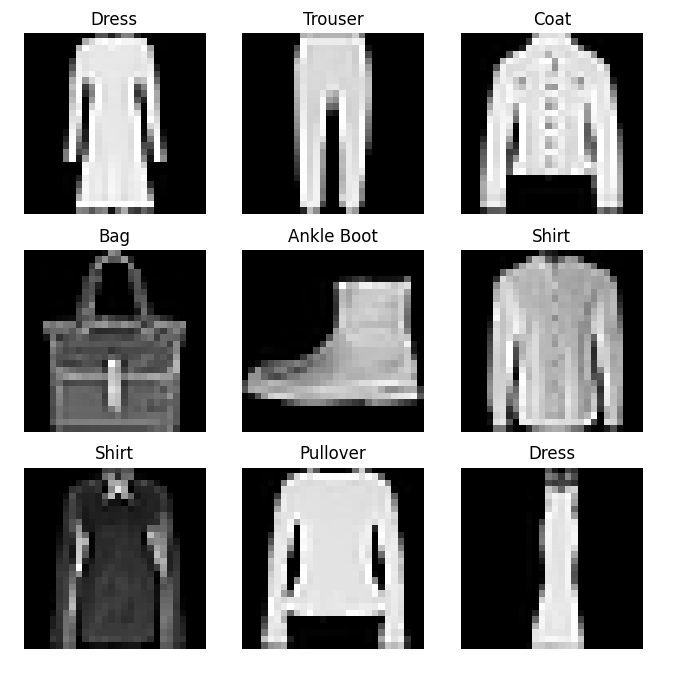

# Use a data "loader" for convenience and speed

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


# Create a model

Uses object oriented notation like we defined 2 classes ago.

To define a neural network in PyTorch, we create a class that inherits
from `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_. 

We define the layers of the network in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [ ]:

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


# Setup loss function and optimizer
To train a model, we need a loss function <https://pytorch.org/docs/stable/nn.html#loss-functions>
and an optimizer <https://pytorch.org/docs/stable/optim.html>.


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Define training and testing data functions

In [ ]:

#######################################################################
# In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
# backpropagates the prediction error to adjust the model's parameters.

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

##############################################################################
# We also check the model's performance against the test dataset to ensure it is learning.

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

##############################################################################
# The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
# parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
# accuracy increase and the loss decrease with every epoch.


# Do the training!

Also test along the way to see how we're doing.

In [ ]:

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


# Save the model

This creates a file containing your model object along with the stored weights. 

Why is this important? Because training can take a long time! You don't want to have to retrain your model every time you want to use it. Just load the saved model from disk.


In [ ]:

######################################################################
# Saving Models
# -------------
# A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")



# Load it

In [ ]:


######################################################################
# Loading Models
# ----------------------------
#
# The process for loading a model includes re-creating the model structure and loading
# the state dictionary into it.

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))


# Make predictions

Sometimes called "inferences."

In [ ]:

#############################################################
# This model can now be used to make predictions.

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

